# Plotting IV Surface

In [1]:
!pip install scikit-optimize

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [3]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.optimize import fsolve
import scipy as sq
from scipy import stats

from skopt.space import Space
from skopt.sampler import Lhs

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [4]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [5]:
synthetic_calls_path = '/content/mydrive/MyDrive/Progetto Stage/data/heston_mc_synthetic_calls.csv'
synthetic_puts_path = '/content/mydrive/MyDrive/Progetto Stage/data/heston_mc_synthetic_puts.csv'

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [7]:
synthetic_calls = pd.read_csv(synthetic_calls_path, index_col=0)
synthetic_puts = pd.read_csv(synthetic_puts_path, index_col=0)

synthetic_calls = reduce_mem_usage(synthetic_calls)
synthetic_puts = reduce_mem_usage(synthetic_puts)

In [8]:
synthetic_options = pd.concat([synthetic_calls, synthetic_puts], axis=0)
synthetic_options = shuffle(synthetic_options, random_state=0)
synthetic_options = synthetic_options.reset_index()
synthetic_options = synthetic_options.drop('index', axis=1)

In [9]:
synthetic_options

,Price,Strike,Type,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,Option Price
0,100,63.0,P,1.512695,-0.217773,0.169189,0.383057,0.170166,0.073792,0.464844,0.039307
1,100,131.0,P,1.711914,-0.697754,0.138306,0.284424,0.338379,0.011772,1.075195,31.203125
2,100,105.0,C,1.034180,-0.854004,0.064819,0.009300,0.458252,0.044006,0.818848,7.769531
3,100,68.0,P,0.064087,-0.727051,0.437988,0.199463,0.429688,0.024658,0.580566,0.789551
4,100,77.0,C,1.453125,-0.607910,0.258301,0.198975,0.073425,0.081238,0.756836,22.828125
...,...,...,...,...,...,...,...,...,...,...,...
605995,100,71.0,P,1.464844,-0.116516,0.241699,0.188965,0.128662,0.054077,0.931152,0.270996
605996,100,57.0,C,1.024414,-0.244263,0.100403,0.268311,0.241821,0.021622,1.020508,41.593750
605997,100,135.0,C,0.631836,-0.868164,0.079468,0.410156,0.410889,0.084778,0.396729,1.692383
605998,100,64.0,P,1.348633,-0.256348,0.433105,0.422852,0.160278,0.024384,0.922852,0.453857


## Preprocessing

In [10]:
synthetic_options = pd.get_dummies(synthetic_options, prefix='', prefix_sep='')

In [11]:
synthetic_options.drop('Option Price', axis=1).columns

Index(['Price', 'Strike', 'Kappa', 'Rho', 'Theta', 'Xi', 'V_0',
       'Interest Rate', 'Time to Expiration', 'C', 'P'],
      dtype='object')

In [12]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(synthetic_options.drop('Option Price', axis=1))
output_data = output_sc.fit_transform(synthetic_options['Option Price'].values.reshape(-1, 1))

## Model

In [13]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [14]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [15]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [16]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [17]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

In [18]:
input_size = 11
output_size = 1
num_layers = 4
hidden_size = 600
batch_size = 1160
epochs = 2000
lr = 0.000125
init_method = 'xaiver uniform'
act_fn = 'LeakyReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()

In [19]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

In [20]:
save_model_path = '../models/final_heston_model.chkpt'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
model.load_state_dict(torch.load(save_model_path, map_location=device))
model = model.to(device)

### IV code

In [21]:
def get_d1_d2(S, X, T, t, r, sigma):
    """
    Compute d1 and d2 values for the black-scholes pricing model


    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate
    :param sigma: underlying volatility
    :return: (d1, d2)
    """
    d1 = (np.log(S / X) + (r + sigma * sigma / 2.) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return d1, d2


def black_scholes(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute option price using the black-scholes model

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the black-scholes option price
    """
    d1, d2 = get_d1_d2(S, X, T, t, r, sigma)
    if o_type == "C":
        return S * stats.norm.cdf(d1, 0, 1) - X * np.exp(-r * (T - t)) * stats.norm.cdf(d2, 0, 1)
    else:
        return X * np.exp(-r * (T - t)) * stats.norm.cdf(-d2, 0, 1) - S * stats.norm.cdf(-d1, 0, 1)

In [22]:
def IV_solver(AmeEurFlag, CallPutFlag, S, X, T, r, c, n, Option_Value):

    def objection_function(IV):
        result = Option_Value - black_scholes(S, X, T, 0, r, IV, CallPutFlag)
        return result
    
    delta = (S - X) / 2
    x0 = np.sqrt(2* np.pi / T) * ((Option_Value - delta) / (S - delta))

    IV_Result = sq.optimize.newton(objection_function, x0=x0)

    return IV_Result

## Generating Samples

In [83]:
space = Space([
               (0.05, 1.1), # time range
               (50, 150), # strikes
               ])
lhs = Lhs(lhs_type="classic", criterion=None)
x = lhs.generate(space.dimensions, 1000, random_state=0)

In [84]:
opt_data = [[100, strike, 1.5, -0.05, 0.45, 0.3, 0.25, 0.02, t, 1, 0] for t, strike in x]

In [85]:
cols = ['Price', 'Strike', 'Kappa', 'Rho', 'Theta', 'Xi', 'V_0',
       'Interest Rate', 'Time to Expiration', 'C', 'P']
call_sample = pd.DataFrame(opt_data, columns=cols)

In [86]:
call_sample

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P
0,100,73,1.5,-0.05,0.45,0.3,0.25,0.02,0.770466,1,0
1,100,85,1.5,-0.05,0.45,0.3,0.25,0.02,0.797323,1,0
2,100,64,1.5,-0.05,0.45,0.3,0.25,0.02,0.375269,1,0
3,100,144,1.5,-0.05,0.45,0.3,0.25,0.02,0.793494,1,0
4,100,72,1.5,-0.05,0.45,0.3,0.25,0.02,0.813185,1,0
...,...,...,...,...,...,...,...,...,...,...,...
195,100,107,1.5,-0.05,0.45,0.3,0.25,0.02,0.232899,1,0
196,100,80,1.5,-0.05,0.45,0.3,0.25,0.02,0.513813,1,0
197,100,69,1.5,-0.05,0.45,0.3,0.25,0.02,1.084425,1,0
198,100,146,1.5,-0.05,0.45,0.3,0.25,0.02,1.062309,1,0


In [87]:
call_sample_t = input_sc.transform(call_sample)
call_sample_t = Variable(torch.Tensor(call_sample_t))

In [88]:
with torch.no_grad():
    pred = model(call_sample_t)

pred = output_sc.inverse_transform(pred.cpu().detach().numpy())
call_sample['Prediction'] = pred
call_sample['Prediction'] = np.abs(call_sample['Prediction'].values)
call_sample['Moneyness'] = call_sample.Price / call_sample.Strike

In [89]:
call_sample['IV'] = np.nan

In [90]:
for i, row in enumerate(call_sample.itertuples(index=False)):
  try:
    iv = IV_solver(
      'a', 
      'C' if row[9] == 1 else 'P',
      row[0], 
      row[1],
      row[8],
      row[7],
      row[7],
      int(row[7] * 365),
      row[11])
    call_sample.loc[i, 'IV'] = iv
  except ValueError as e:
    continue
  except RuntimeError as e:
    continue

In [91]:
call_sample = call_sample.dropna()
call_sample = call_sample[call_sample.IV != 0]
call_sample = call_sample.sort_values(['Moneyness', 'Time to Expiration'], ascending = [True, True])
call_sample

,Price,Strike,Kappa,Rho,Theta,Xi,V_0,Interest Rate,Time to Expiration,C,P,Prediction,Moneyness,IV
10,100,150,1.5,-0.05,0.45,0.3,0.25,0.02,0.881708,1,0,1.321083,0.666667,0.300613
160,100,149,1.5,-0.05,0.45,0.3,0.25,0.02,0.523365,1,0,0.990139,0.671141,0.364305
93,100,149,1.5,-0.05,0.45,0.3,0.25,0.02,1.030473,1,0,1.258774,0.671141,0.269881
44,100,148,1.5,-0.05,0.45,0.3,0.25,0.02,0.502550,1,0,1.011156,0.675676,0.369178
132,100,148,1.5,-0.05,0.45,0.3,0.25,0.02,1.020746,1,0,1.292979,0.675676,0.269659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,100,56,1.5,-0.05,0.45,0.3,0.25,0.02,0.498985,1,0,44.597900,1.785714,0.340956
63,100,55,1.5,-0.05,0.45,0.3,0.25,0.02,0.052881,1,0,45.842525,1.818182,1.702933
147,100,54,1.5,-0.05,0.45,0.3,0.25,0.02,0.485621,1,0,46.531036,1.851852,0.311641
81,100,53,1.5,-0.05,0.45,0.3,0.25,0.02,0.256305,1,0,47.377071,1.886792,0.577474


In [93]:
X_axis = call_sample.Moneyness
Y_axis = call_sample['Time to Expiration']
Z_axis = call_sample.IV

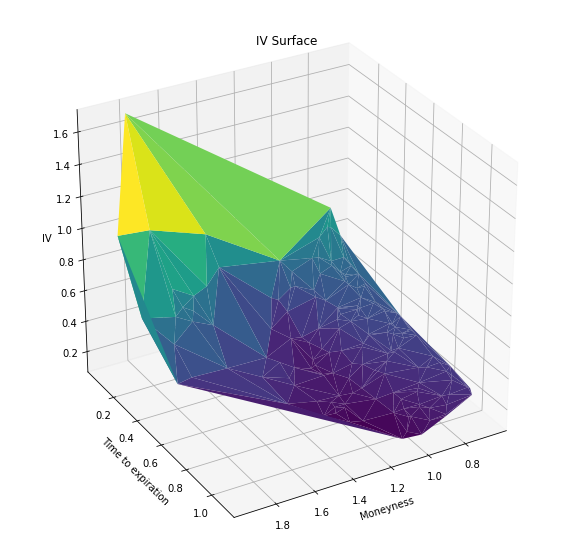

In [107]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_axis, Y_axis, Z_axis, 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('IV Surface')

ax.view_init(30, 60)

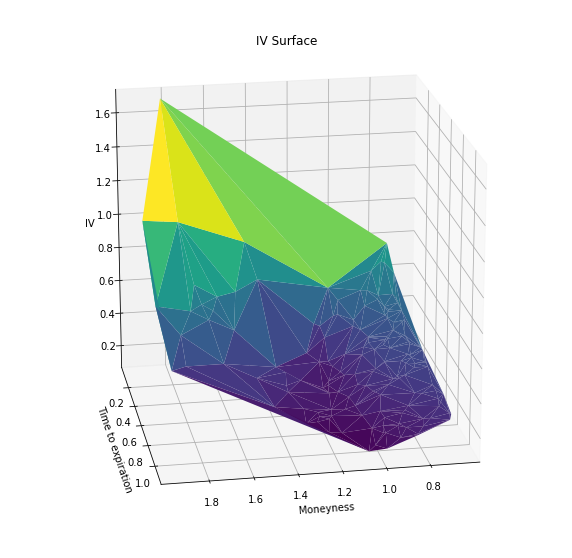

In [106]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_axis, Y_axis, Z_axis, 
                linewidth=0.2, antialiased=True, cmap='viridis')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to expiration')
ax.set_zlabel('IV')
ax.set_title('IV Surface')

ax.view_init(20, 80)

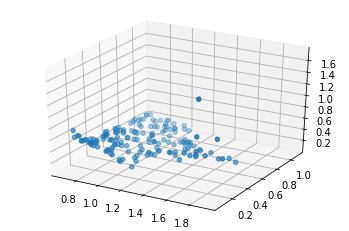

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_axis, Y_axis, call_sample.IV)

plt.show()